In [1]:
using PyPlot
using QSimulator
using LsqFit

# Fitting models to be used later

In [2]:
model_t2(x, p) = (exp.(-x ./ p[1]) .* cos.(2π .* p[2] .* x .- p[3]) + 1.0) / 2.0;
model_t1(x, p) = exp.(-x ./ p[1]);

# Bare Parameters for a 2 level system

In [3]:
Ω = .01 # microwave nutation frequency in GHz
Tgate = 1 / 4Ω # time for a 90 degree pulse

qubit_freq = 1.0

q0 = DuffingTransmon("q0", 2, DuffingSpec(qubit_freq, -.2));

# Helper functions that 
### Build  a driven CompositeQSystem 
### Define a pulse that drives the system

In [4]:
square_pulse(ϕ) = t -> Ω * cos(2π * qubit_freq * t + ϕ)

function make_cqs(lind_ops; rf_drive=false, ϕ=0)
    cqs = CompositeQSystem([q0])
    add_hamiltonian!(cqs, q0)
    if rf_drive == true
        add_hamiltonian!(cqs, microwave_drive(q0, square_pulse(ϕ)), q0)
    end
    for lind_op = lind_ops
        add_lindblad!(cqs, lind_op, [q0])
    end
    
    return cqs
end;

# A model of an experiment that measures T1 decay

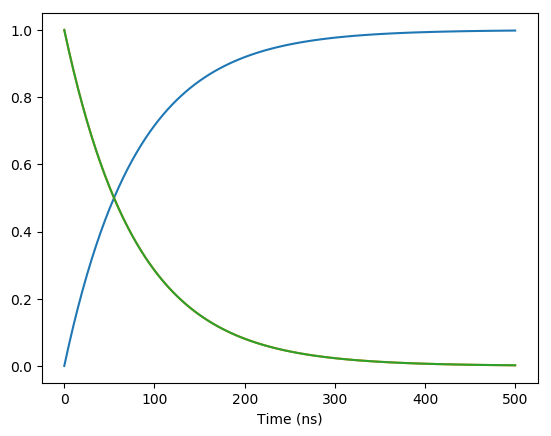

Fit T₁ is 0.08 μs


PyObject Text(0.5,24,'Time (ns)')

In [5]:
T₁ = 500 # in ns
γ₁ = 1. / T₁

cqs = make_cqs([√γ₁ * lowering(q0)])

ρ0 = ComplexF64[0 0; 0 1] # start in the excited state
times = collect(linspace(0, 500, 101))
ρs = me_state(cqs, times, ρ0)

# extract ground and excited state populations
ρgg = [real(s[1, 1]) for s in ρs]
ρee = [real(s[2, 2]) for s in ρs]

p0 = [100.] # starting guess of 100ns T₁
fit = curve_fit(model_t1, times, ρee, p0)
p_fit = fit.param

println("Fit T₁ is $(round(Int,  p_fit[1]) / 1000.) μs")

plot(times, ρgg, label="Ground State Pop.")
plot(times, ρee, label="Excited State Pop.")
plot(times, model_t1(times, p_fit), label="Model Fit")
xlabel("Time (ns)")

# A model of a Ramsey experiment that calculates $T_ϕ$ from $T_2$

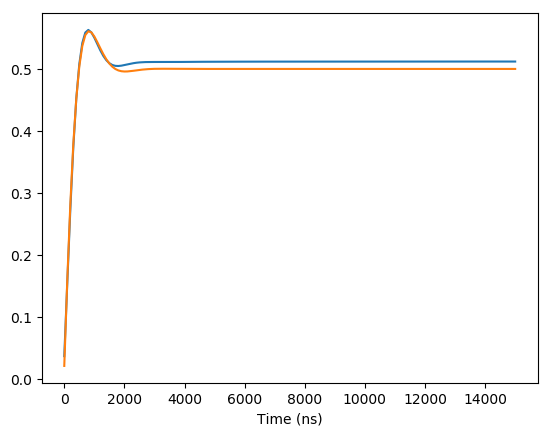

Fit Tϕ is 0.459

PyObject Text(0.5,24,'Time (ns)')

In [6]:
# Model T₁ decay and pure dephasing Tϕ
T₁ = 10000. # in ns
Tϕ = 3000.

γ₁ = 1.0 / T₁
γϕ = 1.0 / Tϕ

σz = ComplexF64[1 0; 0 -1]

c_ops = [√γ₁ * lowering(q0), √γϕ * σz / √2] # cooling and dephasing Lindlbad operators

cqs = make_cqs(c_ops, rf_drive=true)

# First π/2 pulse
ρ0 = ComplexF64[1 0; 0 0] # start in ground state
ρ_X = me_state(cqs, Tgate, ρ0)

# Free evolution
cqs = make_cqs(c_ops, rf_drive=false)
wait_times = collect(0:100:15000)
ρs_free = me_state(cqs, wait_times, ρ_X)

# Rate of phase accrual for the second pulse to imprint artificial detuning
det = .5 / 1000

t2_expt = Float64[]
for (wait_time, ρ) = zip(wait_times, ρs_free)
    ϕ = 2π * (qubit_freq - det) * wait_time
    
    # Second π/2 pulse
    cqs = make_cqs(c_ops, rf_drive=true, ϕ=ϕ)
    ρ_XX = me_state(cqs, Tgate, ρ)
    
    # Ground state probability
    push!(t2_expt, real(ρ_XX[1, 1]))
end

p0 = [T₁, .5 / 1000., 0.0]
fit = curve_fit(model_t2, wait_times, t2_expt, p0)
p_fit = fit.param

fit_Tϕ = 1/(1/p_fit[1] - 1 / 2T₁)
print("Fit Tϕ is $(round(Int, fit_Tϕ) / 1000)")

plot(wait_times, t2_expt, label="Ground State Pop.")
plot(wait_times, model_t2(wait_times, p_fit), label="Model Fit")
xlabel("Time (ns)")